# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
n = 5  # number of variables

n_jobs = -3 #joblib multiporcessing kernels

interpretation_net_training_size = 333#2**(2**(4)) #select subset size for interpretation-net training

number_of_lambda_nets = interpretation_net_training_size #manually specify number of formulas included in the loaded dataset


#specify interpretation net structure
optimizer = 'adadelta'
dropout = 0.0
epochs = 200
batch_size = 64
interpretation_network_layers = [2048]


#lambda net specifications for loading (need to be set according to lambda net training to load correct weights)
epochs_lambda = 200
lambda_network_layers = [(2**n) * 5]#[64, 32, 16, 8, 4, 2] (2**n) * 5
batch_size_lambda = 2**n


#set if multi_epoch_analysis should be performed
multi_epoch_analysis = True
each_epochs_save_lambda = 5 #for loading correct weight file, None if no checkpointing (otherwise set according to lambda-net training)
epoch_start = 0 #use to skip first epochs in multi_epoch_analysis

each_epochs_int_training = 5 #usually equal to each_epochs_save_lambda but can also be lower if not all saved weights should be considered

#set if samples analysis should be performed
samples_list = None#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 36864]
                            
                            
#Decide whether to predict what the model should have learned (False) or has learned (True)
second_approach = False


In [2]:
##############DO NOT CHANGE###################
RANDOM_SEED = 42

all_lambda_nets_included = True if (number_of_lambda_nets == 2**(2**(4)) and n ==4) else False #can be set true if n=4 (if all possible functions should be included in dataset)

variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

#set true to round lambda net output to 0/1
y_data_0_1 = True

size_string_lambda = '_all' if all_lambda_nets_included else '_' +  str(number_of_lambda_nets)
layers_str = ''.join([str(neurons) + '-' for neurons in lambda_network_layers])
structure = '_shuffleSeedMethod' + '_' + layers_str + str(epochs_lambda) + 'e' + str(batch_size_lambda) + 'b' 

if interpretation_net_training_size==2**(2**(n)) and all_lambda_nets_included:
    size_string_int = '_all'  
elif interpretation_net_training_size==2**(2**(n)) and not all_lambda_nets_included:
    size_string_int = '_' + str(number_of_lambda_nets)
elif not interpretation_net_training_size==2**(2**(n)) and all_lambda_nets_included:
    size_string_int = '_'  + str(interpretation_net_training_size)
elif not interpretation_net_training_size==2**(2**(n)) and not all_lambda_nets_included:
    size_string_int = '_' + str(number_of_lambda_nets)

interpretation_network_string = 'drop' + str(dropout) + 'e' + str(epochs) + 'b' + str(batch_size) + '_' + str(interpretation_network_layers)

use_gpu = False
if use_gpu:
    gpu_numbers = '0'
else:
    gpu_numbers = ''
                                               
#This variables represents only the boolean algebra without any zhegalkin polynomials
#If this is true, evaluate_zhegalkin has to be 0
evaluate_boolean = True


#If we train on the boolean values, this variable is set to False and in the learning method 
#the results are transofmred to the zhegalkin polynomial for the evaluation
evaluate_zhegalkin = False if evaluate_boolean == True else True
                                               
                                               
print('Variables: ' + str(n) + ' (' + variables + ')')
print('Loaded Lambda Nets: ' + str(number_of_lambda_nets))
print('Interpretation-Model Dataset Size: ' + str(interpretation_net_training_size))
   
                                               

Variables: 5 (abcde)
Loaded Lambda Nets: 333
Interpretation-Model Dataset Size: 333


## Imports

In [3]:
import ttg
from itertools import product  
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers
import shutil
import psutil
from functools import reduce

from prettytable import PrettyTable
import colored

from datetime import datetime


from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot.keras import PlotLossesCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns

import scipy.special as scipy

np.set_printoptions(suppress=True)

import tensorflow as tf
import random 
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
from similaritymeasures import frechet_dist, area_between_two_curves, dtw


Using TensorFlow backend.


In [4]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors)

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs:
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs:
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size],
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right

def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

In [6]:
'''

Methods to convert to zhegalkin representation if those aren't evaluated. Depends on the boolen variable evaluate_zhegalkin

'''

def convert_to_zhegalkin(predictions):
    final_list = list()

    
    for pred_array in predictions:

        result = list()
        '''
        This is how you call the function
        '''
        for i in range(2**n):
            pred_array, result = create_zhegalkin_matrix(pred_array, result)
        final_list.append(result)
        
    return final_list

def create_zhegalkin_matrix(truth_val, result_list):
    
    '''
    Use of the triangular shape.
    New array is always reduced by one ine
    '''
    new_array = list()
    
    
    for i in range(len(truth_val)):
        if(i == 0):
            result_list.append(truth_val[0])
        else:
            tmp = truth_val[i-1] ^ truth_val[i]
            new_array.append(tmp)
        
    
    return new_array, result_list
    
'''
Lookup table for function value computation of the zhegalkin polynom. This one is called
in the next cell
'''
lookup_comp = {
    '0': [var for var in range(n)],
    '1': [var for var in range(n) if var != n-1],
    '2': [var for var in range(n) if var != n-2],
    '3': [var for var in range(n) if var != n-1 and var != n-2],
    '4': [var for var in range(n) if var != n-3],
    '5': [var for var in range(n) if var != n-3 and var != n-1],
    '6': [var for var in range(n) if var != n-3 and var != n-2],
    '7': [var for var in range(n) if var == n-4],
    '8': [var for var in range(n) if var != n-4],
    '9': [var for var in range(n) if var != n-4 and var != n-1],
    '10': [var for var in range(n) if var != n-4 and var != n-2],
    '11': [var for var in range(n) if var == n-3],
    '12': [var for var in range(n) if var != n-4  and var != n-3],
    '13': [var for var in range(n) if var == n-2],
    '14': [var for var in range(n) if var == n-1],
    #if empty array, take the value that is in the for the xor sum
    '15': []
}
    

### Generate Truth Table Identifiers

In [7]:
table = ttg.Truths([variable for variable in variables[:n]])
table_pd = table.as_pandas()

evaluation_dataset = list()

for key, evals in table_pd.iterrows():
    evaluation_dataset.append(np.array(evals.values))


## Loss/Error functions

In [8]:
def accuracy_multilabel(y_true, y_pred):
    if 'float' in str(y_true[0].dtype):
            y_true = tf.math.round(y_true)
    return tf.reduce_all(K.equal(K.equal(y_true, tf.math.round(y_pred)), True), axis=1)#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def binary_crossentropy_multilabel(y_true, y_pred): 
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

def logloss_manual(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    """ Vectorised computation of logloss """  

    #cap in official Kaggle implementation,   
    #per forums/t/1576/r-code-for-logloss  
    epsilon = 1e-7  
    y_pred = np.maximum(epsilon, y_pred)  
    y_pred = np.minimum(1-epsilon, y_pred)  

    y_true = np.maximum(epsilon, y_true)  
    y_true = np.minimum(1-epsilon, y_true)  
     
    ll = sum(y_true*np.lib.scimath.log(y_pred) + np.subtract(1,y_true)*np.lib.scimath.log(np.subtract(1,y_pred)))
    ll = ll * -1.0/len(y_true)  
    
    try:
        if len(ll) > 1:
            ll = np.mean(ll)
    except TypeError:
        pass
    
    return ll

In [9]:
def accuracy_complete(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    counter_total = 0
    counter_correct = 0
    for y_true_entry, y_pred_entry in zip(y_true, y_pred):        
        counter_total +=1
        y_pred_entry = np.around(y_pred_entry).astype('int') 
        if np.array_equal(y_true_entry, y_pred_entry):
            counter_correct +=1
            
    return counter_correct/counter_total


def accuracy_complete_with_threshold(y_true, y_pred, threshold):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    counter_total = 0
    counter_correct = 0
    for y_true_entry, y_pred_entry in zip(y_true, y_pred):
        y_true_entry_treshold = []
        y_pred_entry_treshold = []
        for value_true, value_pred in zip(y_true_entry, y_pred_entry):
            if value_pred < threshold or value_pred > (1-threshold):
                y_true_entry_treshold.append(value_true)
                y_pred_entry_treshold.append(value_pred)
        y_true_entry_treshold = np.array(y_true_entry_treshold)
        y_pred_entry_treshold = np.around(np.array(y_pred_entry_treshold)).astype('int') 
            
        counter_total +=1
        if np.array_equal(y_true_entry_treshold, y_pred_entry_treshold):
            counter_correct +=1
            
    return counter_correct/counter_total
        

def accuracy_minterm_with_threshold(y_true, y_pred, threshold):
    
    '''
    y_true = true values that are 0 or 1
    y_pred = proba values that are float numbers
    treshhold = treshhold where we round
    '''
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    accuracy_final = 0
    counter_array = 0
    for pred_array in y_pred:
        counter_ele = 0
        normalization_counter = 0
        accuracy_tmp = 0

        for pred in pred_array:
            if pred < threshold or pred > (1-threshold):
                accuracy_tmp += (np.around(pred).astype('int')) == y_true[counter_array][counter_ele]
                normalization_counter += 1
            counter_ele += 1
        
        try:
            accuracy_tmp = accuracy_tmp / normalization_counter
        except:
            accuracy_tmp = 0
        accuracy_final += accuracy_tmp
        
        counter_array += 1    
        

    #Normalize the accuracy
    accuracy_final = accuracy_final / (counter_array)
    return accuracy_final


def accuracy_minterm(y_true, y_pred):
    
    '''
    y_true = true values that are 0 or 1
    y_pred = proba values that are float numbers
    treshhold = treshhold where we round
    '''
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    counter_array = 0
    accuracy_final = 0
    for pred_array in y_pred:
        counter_ele = 0
        accuracy_tmp = 0

        for pred in pred_array:
            accuracy_tmp += (np.around(pred).astype('int')) == y_true[counter_array][counter_ele]
            counter_ele += 1
            #Normalize the accuracy
        accuracy_tmp = accuracy_tmp / counter_ele
        accuracy_final += accuracy_tmp
        
        counter_array += 1   

    
    accuracy_final = accuracy_final / (counter_array)
    return accuracy_final

In [10]:
def calcualate_function(zhegalkin_or_boolean_polynom, variable_values_from_truthtable, counter_boolean):
    if evaluate_zhegalkin:
        counter = 0
        result = None
        for zhegalkin_val in zhegalkin_or_boolean_polynom:
            if zhegalkin_val == 1:
                #take the lookup comp to determine which values to summarze with and 
                #afterwards the results is taken to the xor sum
                vals_logical_and = lookup_comp[str(counter)]
                tmp = 1
                #Determine and sum
                for vals in vals_logical_and:
                    tmp = (tmp & variable_values_from_truthtable[vals])
                    
                if result == None:
                    result = tmp 
                else:
                    result = tmp ^ result
            counter += 1
        if result == None:
            #print(zhegalkin_polynom)
            result = 0            
    elif evaluate_boolean:
        result = zhegalkin_or_boolean_polynom[counter_boolean]
        

    
    return result
    
#Variablen werden mitgegeben
def calcualate_function_with_data(zhegalkin_or_boolean_polynom, variable_values_from_truthtable, counter_boolean):
    if evaluate_zhegalkin:
        counter = 0
        result = None
        for zhegalkin_val in zhegalkin_or_boolean_polynom:
            if zhegalkin_val == 1:
                #take the lookup comp to determine which values to summarze with and 
                #afterwards the results is taken to the xor sum
                vals_logical_and = lookup_comp[str(counter)]
                tmp = 1
                #Determine and sum
                for vals in vals_logical_and:
                    tmp = (tmp & variable_values_from_truthtable[vals])

                if result == None:
                    result = tmp ^ (not tmp)
                else:
                    result = tmp ^ result
            counter += 1

        if result == None:
            #print(zhegalkin_polynom)
            result = 0 
    elif evaluate_boolean:
        result = zhegalkin_or_boolean_polynom[counter_boolean]
        

    return result, np.append(zhegalkin_or_boolean_polynom, result)

 
def calculate_function_values_from_function(true_value_valid, true_value_test, pred_value_valid, pred_value_test):

    #print('method_call')
    
    if isinstance(true_value_valid, pd.DataFrame):
        true_value_valid = true_value_valid.values
    if isinstance(true_value_test, pd.DataFrame):
        true_value_test = true_value_test.values
    if isinstance(pred_value_valid, pd.DataFrame):
        pred_value_valid = pred_value_valid.values
    if isinstance(pred_value_test, pd.DataFrame):
        pred_value_test = pred_value_test.values
        
        
    true_value_fv_valid = []
    true_value_fv_test = []
    pred_value_fv_valid = []
    pred_value_fv_test = []
    
    true_value_fv_valid_with_variable_values = []
    true_value_fv_test_with_variable_values = []
    pred_value_fv_valid_with_variable_values = []
    pred_value_fv_test_with_variable_values = []
    
    #print('start_loop')
    if evaluate_boolean:
        counter_boolean = 0
    else:
        counter_boolean = None
    for evaluation in evaluation_dataset:
        true_function_value_valid, true_function_value_valid_with_variable_values = calcualate_function_with_data(true_value_valid, evaluation, counter_boolean)
        true_function_value_test, true_function_value_test_with_variable_values = calcualate_function_with_data(true_value_test, evaluation, counter_boolean)
        pred_function_value_valid, pred_function_value_valid_with_variable_values = calcualate_function_with_data(pred_value_valid, evaluation, counter_boolean)
        pred_function_value_test, pred_function_value_test_with_variable_values = calcualate_function_with_data(pred_value_test, evaluation, counter_boolean)

        true_value_fv_valid.append(true_function_value_valid)
        true_value_fv_test.append(true_function_value_test)
        pred_value_fv_valid.append(pred_function_value_valid)
        pred_value_fv_test.append(pred_function_value_test)

        true_value_fv_valid_with_variable_values.append(true_function_value_valid_with_variable_values)
        true_value_fv_test_with_variable_values.append(true_function_value_test_with_variable_values)
        pred_value_fv_valid_with_variable_values.append(pred_function_value_valid_with_variable_values)
        pred_value_fv_test_with_variable_values.append(pred_function_value_test_with_variable_values)
        if counter_boolean != None:
            counter_boolean += 1
    #print('end_loop')
    #print(true_value_fv_valid, true_value_fv_test, pred_value_fv_valid, pred_value_fv_test, true_value_fv_valid_with_coeff, true_value_fv_test_with_coeff, pred_value_fv_valid_with_coeff, pred_value_fv_test_with_coeff)

    return true_value_fv_valid, true_value_fv_test, pred_value_fv_valid, pred_value_fv_test, true_value_fv_valid_with_variable_values, true_value_fv_test_with_variable_values, pred_value_fv_valid_with_variable_values, pred_value_fv_test_with_variable_values


#evaluation_dataset muss in den folgenden metriken angepasst werden, 
#dass es den kompletten trainings datenpunkten entspricht

def mean_absolute_error_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
       
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(true_values-pred_values)))
     
    result_array = np.array(result_list)
                
    #error value calculation    
    result = np.mean(result_array)  
    
    
    #error value calculation    
    #result = np.mean(np.abs(y_true-y_pred))
    
    
    
    
    return result

def root_mean_squared_error_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values      
     
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sqrt(np.mean((true_values-pred_values)**2)))
     
    result_array = np.array(result_list)  
    
    #error value calculation    
    result = np.mean(result_array)     
    
    #error value calculation    
    #result = np.sqrt(np.mean((y_true-y_pred)**2))
    
    return result

def mean_absolute_percentage_error_function_values(y_true, y_pred, epsilon=10e-3):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
     
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(((true_values-pred_values)/(true_values+epsilon)))))
     
    result_array = np.array(result_list)  
    
    #error value calculation    
    result = np.mean(result_array)    
       
    #error value calculation    
    #result = np.mean(np.abs(((y_true-y_pred)/(y_true+epsilon))))
        
    
    return result

def r2_score_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(r2_score(true_values, pred_values))
     
    result_array = np.array(result_list)  
    
    #error value calculation    
    result = np.mean(result_array)     
    
    #error value calculation    
    #result = r2_score(y_true, y_pred)
    
    return result

def relative_absolute_average_error_function_values(y_true, y_pred, epsilon=10e-7):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sum(np.abs(true_values-pred_values))/(2**n*np.std(true_values)+epsilon))
     
    result_array = np.array(result_list)  
    
    #error value calculation    
    result = np.mean(result_array)       
    
    
    return result

def relative_maximum_average_error_function_values(y_true, y_pred, epsilon=10e-7):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.max(true_values-pred_values)/(np.std(true_values)+epsilon))
     
    result_array = np.array(result_list)  
    
    #error value calculation    
    result = np.mean(result_array)   
    
    
    #error value calculation    
    #result = np.max(y_true-y_pred)/np.std(y_true) #correct STD?
    
    return result

def mean_area_between_two_curves_function_values(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
      
    assert(number_of_variables==1)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(area_between_two_curves(true_values, pred_values))
     
    result_array = np.array(result_list)
        
    #error value calculation    
    result = np.mean(result_array)    
    return result


## Load Data 

In [11]:
def load_data(index):
    
    if psutil.virtual_memory().percent > 90:
        raise SystemExit("Out of RAM!")
    
    filename = 'weights_formula_' + str(n)  + size_string_lambda +  '_epoch_' + str((index+1)*each_epochs_save_lambda).zfill(3) + structure + str(RANDOM_SEED)
    filename_y_data = 'weights_with_y_formula_' + str(n) + size_string_lambda + '_epoch_' + str((index+1)*each_epochs_save_lambda).zfill(3) + structure + str(RANDOM_SEED)

    path = './data/weights/' + foldername + filename + '.txt'
    path_with_y = './data/weights/' + foldername + filename_y_data + '.txt'
    
    import os
    if os.path.exists(path_with_y):
        y_included = True
        weight_data = pd.read_csv(path_with_y, sep=",", header=None)

    else:
        y_included = False
        weight_data = pd.read_csv(path, sep=",", header=None)
                    
    return weight_data
    

In [12]:
#LOAD DATA
if multi_epoch_analysis:  
    weight_data_list = []
    
    foldername = 'weights_formula_' + str(n) + size_string_lambda + structure + str(RANDOM_SEED) + '/'
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    weight_data_list = parallel(delayed(load_data)(index) for index in range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda))  
    del parallel
    
    weight_data = weight_data_list[-1]
    
    filename = 'weights_formula_' + str(n) + size_string_lambda +  '_epoch_' + str(epochs_lambda).zfill(3) + structure + str(RANDOM_SEED)
    filename_y_data = 'weights_with_y_formula_' + str(n) + size_string_lambda +  '_epoch_' + str(epochs_lambda).zfill(3) + structure + str(RANDOM_SEED)

else:
    foldername = 'weights_formula_' + str(n) + size_string_lambda + structure + str(RANDOM_SEED) + '/'

    filename = 'weights_formula_' + str(n) + size_string_lambda +  '_epoch_' + str(epochs_lambda).zfill(3) + structure + str(RANDOM_SEED)
    filename_y_data = 'weights_with_y_formula_' + str(n) + size_string_lambda +  '_epoch_' + str(epochs_lambda).zfill(3) + structure + str(RANDOM_SEED)

    path = './data/weights/' + foldername + filename + '.txt'
    path_with_y = './data/weights/' + foldername + filename_y_data + '.txt'


    import os
    if os.path.exists(path_with_y):
        y_included = True
        weight_data = pd.read_csv(path_with_y, sep=",", header=None)
    else:
        y_included = False
        weight_data = pd.read_csv(path, sep=",", header=None)
    

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done  11 out of  40 | elapsed:    1.9s remaining:    4.9s
[Parallel(n_jobs=-3)]: Done  25 out of  40 | elapsed:    2.1s remaining:    1.3s
[Parallel(n_jobs=-3)]: Done  40 out of  40 | elapsed:    2.3s finished


## Data Inspection

In [13]:
if 'weight_data' not in locals():
    weight_data = weight_data_list[-1]

In [14]:
weight_data.describe()

,1,2,3,4,5,6,7,8,9,10,...,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218
count,333.0,333.0,333.0,333.000000,333.0,333.000000,333.000000,333.000000,333.0,333.000000,...,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,1.0,1.0,1.0,0.921922,1.0,0.957958,0.954955,0.537538,1.0,0.957958,...,0.086382,0.085194,-0.096125,-0.050313,-0.010941,-0.167155,-0.142727,-0.124129,-0.047344,0.054855
std,0.0,0.0,0.0,0.268698,0.0,0.200987,0.207715,0.499339,0.0,0.200987,...,0.004292,0.008495,0.017682,0.005169,0.007287,0.006529,0.001795,0.015255,0.012547,0.074818
min,1.0,1.0,1.0,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,...,0.079145,0.066655,-0.143366,-0.064278,-0.029256,-0.181275,-0.147416,-0.173898,-0.079878,-0.148480
25%,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,0.000000,1.0,1.000000,...,0.085104,0.078608,-0.107622,-0.054240,-0.016279,-0.172067,-0.144225,-0.134571,-0.056287,0.010249
50%,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,...,0.085992,0.084640,-0.095924,-0.050095,-0.010596,-0.167094,-0.142295,-0.124098,-0.047598,0.058735
75%,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,...,0.091113,0.091287,-0.082797,-0.046565,-0.005492,-0.162739,-0.140926,-0.113012,-0.038262,0.103749
max,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,...,0.094304,0.107991,-0.055412,-0.038092,0.006265,-0.155716,-0.140339,-0.084452,-0.014100,0.221321


In [15]:
weight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Columns: 1219 entries, 0 to 1218
dtypes: float64(1153), int64(64), object(2)
memory usage: 3.1+ MB


In [16]:
np.max(weight_data.describe().loc['max'])

1.0

In [17]:
np.min(weight_data.describe().loc['min'])

-0.25606376

## Generate Datasets for Interpretation-Net training

In [18]:
#generate train, test and validation data for training
if multi_epoch_analysis:
    X_train_list = []
    y_train_with_formula_list = []
    y_train_list = []
    
    X_valid_list = []
    y_valid_with_formula_list = []
    y_valid_list = []
    
    X_test_list = []
    y_test_with_formula_list = []
    y_test_list = []
    for weight_data in tqdm(weight_data_list):
        
        if psutil.virtual_memory().percent > 80:
            raise SystemExit("Out of RAM!")
            
        weight_data = weight_data.sort_values([i+1 for i in range(2**n)], ascending=True).reset_index(drop=True)
        
        X_data = weight_data.sample(n=interpretation_net_training_size, random_state=RANDOM_SEED).drop([i for i in range(((2**n+1) * 3)-1)], axis=1)
        #Generate both directories
        zhegalkin_df = weight_data.sample(n=interpretation_net_training_size, random_state=RANDOM_SEED)[[i for i in range((2**n+1))]]
        boolean_df = weight_data.sample(n=interpretation_net_training_size, random_state=RANDOM_SEED)[[i for i in range((2**n+1), (2**n+1) * 2)]]
        y_data_2nd = weight_data.sample(n=interpretation_net_training_size, random_state=RANDOM_SEED)[[i for i in range((2**n+1) * 2, ((2**n+1) * 3)-1)]]


        
        if y_data_0_1:
            zhegalkin_df[[i for i in range(1, 2**n+1)]] = zhegalkin_df[[i for i in range(1, 2**n+1)]].round(0).astype(int)
        else:
            zhegalkin_df[[i for i in range(1, 2**n+1)]] = zhegalkin_df[[i for i in range(1, 2**n+1)]].astype(float)

        zhegalkin_df = zhegalkin_df.rename(columns = {0:'formula'})
        boolean_df = boolean_df.rename(columns = {2**n+1:'formula'})

         #Determine y_data of approach 1st or 2nd
        if second_approach:
            train_data = y_data_2nd
        else:
            if evaluate_zhegalkin:
                train_data = zhegalkin_df
            else:
                train_data = boolean_df



        if number_of_lambda_nets > 65536:
            X_train_with_valid, X_test, y_train_with_valid_with_formula, y_test_with_formula = train_test_split(X_data, train_data, test_size=int(65536*0.25), random_state=RANDOM_SEED)
            X_train, X_valid, y_train_with_formula, y_valid_with_formula = train_test_split(X_train_with_valid, y_train_with_valid_with_formula, test_size=int(int(65536*0.75)*0.25), random_state=RANDOM_SEED)           
        else:
            X_train_with_valid, X_test, y_train_with_valid_with_formula, y_test_with_formula = train_test_split(X_data, train_data, test_size=0.25, random_state=RANDOM_SEED)
            X_train, X_valid, y_train_with_formula, y_valid_with_formula = train_test_split(X_train_with_valid, y_train_with_valid_with_formula, test_size=0.25, random_state=RANDOM_SEED)           

        X_train_list.append(X_train)
        y_train_with_formula_list.append(y_train_with_formula)
        y_train_list.append(y_train_with_formula.drop(['formula'], axis=1))

        X_valid_list.append(X_valid)
        y_valid_with_formula_list.append(y_valid_with_formula)
        y_valid_list.append(y_valid_with_formula.drop(['formula'], axis=1))


        X_test_list.append(X_test)
        y_test_with_formula_list.append(y_test_with_formula)
        y_test_list.append(y_test_with_formula.drop(['formula'], axis=1))    

        del weight_data, X_train_with_valid, y_train_with_valid_with_formula
else:
    X_data = weight_data.sample(n=interpretation_net_training_size, random_state=RANDOM_SEED).drop([i for i in range(((2**n+1) * 3) -1)], axis=1)
    zhegalkin_df = weight_data.sample(n=interpretation_net_training_size, random_state=RANDOM_SEED)[[i for i in range((2**n+1))]]
    boolean_df = weight_data.sample(n=interpretation_net_training_size, random_state=RANDOM_SEED)[[i for i in range((2**n+1), (2**n+1) * 2)]]
    y_data_2nd = weight_data.sample(n=interpretation_net_training_size, random_state=RANDOM_SEED)[[i for i in range((2**n+1) * 2, ((2**n+1) * 3)-1)]]

   
    #y_data_with_formula = weight_data.sample(n=size, random_state=RANDOM_SEED)[[i for i in range((2**n+1) * 2)]]

    if y_data_0_1:
        zhegalkin_df[[i for i in range(1, 2**n+1)]] = zhegalkin_df[[i for i in range(1, 2**n+1)]].round(0).astype(int)
    else:
        zhegalkin_df[[i for i in range(1, 2**n+1)]] = zhegalkin_df[[i for i in range(1, 2**n+1)]].astype(float)        

    zhegalkin_df = zhegalkin_df.rename(columns = {0:'formula'})
    boolean_df = boolean_df.rename(columns = {2**n+1:'formula'})


    #Determine y_data of approach 1st or 2nd
    if second_approach:
        train_data = y_data_2nd
    else:
        if evaluate_zhegalkin:
            train_data = zhegalkin_df
        else:
            train_data = boolean_df

    

    if number_of_lambda_nets > 65536:
        X_train_with_valid, X_test, y_train_with_valid_with_formula, y_test_with_formula = train_test_split(X_data, train_data, test_size=int(65536*0.25), random_state=RANDOM_SEED)
        X_train, X_valid, y_train_with_formula, y_valid_with_formula = train_test_split(X_train_with_valid, y_train_with_valid_with_formula, test_size=int(int(65536*0.75)*0.25), random_state=RANDOM_SEED)           
    else:
        X_train_with_valid, X_test, y_train_with_valid_with_formula, y_test_with_formula = train_test_split(X_data, train_data, test_size=0.25, random_state=RANDOM_SEED)
        X_train, X_valid, y_train_with_formula, y_valid_with_formula = train_test_split(X_train_with_valid, y_train_with_valid_with_formula, test_size=0.25, random_state=RANDOM_SEED)           

        
    y_train = y_train_with_formula.drop(['formula'], axis=1)
    y_valid = y_valid_with_formula.drop(['formula'], axis=1)
    y_test = y_test_with_formula.drop(['formula'], axis=1)



In [19]:
y_valid_with_formula

,formula,34,35,36,37,38,39,40,41,42,...,56,57,58,59,60,61,62,63,64,65
174,~a and ~b and ~c and ~d and ~e or ~a and ~b a...,0,0,1,0,1,0,1,0,0,...,0,0,1,0,1,1,0,1,0,1
47,~a and ~b and ~c and ~d and e or ~a and ~b an...,1,1,1,1,0,1,0,0,1,...,1,0,1,1,0,0,0,1,1,0
227,~a and ~b and c and ~d and ~e or ~a and ~b an...,0,0,0,0,0,0,1,1,1,...,0,1,0,1,0,1,0,0,0,0
129,~a and ~b and ~c and ~d and ~e or ~a and ~b a...,0,0,1,0,1,1,0,0,0,...,1,0,1,0,1,1,0,0,1,1
288,~a and ~b and ~c and ~d and ~e or ~a and ~b a...,0,1,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,1
251,~a and ~b and ~c and d and e or ~a and ~b and...,1,0,0,1,0,1,0,1,0,...,1,1,1,0,0,1,1,0,0,0
64,~a and ~b and ~c and ~d and ~e or ~a and ~b a...,1,0,1,1,0,1,0,1,0,...,1,1,0,1,1,0,0,1,0,1
314,~a and ~b and ~c and ~d and ~e or ~a and ~b a...,1,1,0,1,0,0,1,0,0,...,1,0,1,0,1,1,0,0,0,1
179,~a and ~b and ~c and ~d and e or ~a and ~b an...,1,1,0,1,1,0,1,1,1,...,0,1,0,0,0,0,1,1,1,0
169,~a and ~b and ~c and ~d and ~e or ~a and ~b a...,1,0,0,1,1,1,1,0,0,...,1,0,1,1,0,1,0,0,0,1


In [20]:
if multi_epoch_analysis:
    print_head = X_train_list[-1].head()
else:
    print_head = X_train.head()
print_head

,98,99,100,101,102,103,104,105,106,107,...,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218
255,0.184885,-0.151034,-0.122223,-0.043227,0.009251,-0.018167,-0.154285,-0.155764,-0.173181,-0.025636,...,0.080166,0.077713,-0.104577,-0.044757,-0.012631,-0.157157,-0.141690,-0.145527,-0.051592,0.094720
42,0.183615,-0.149899,-0.128717,-0.048099,-0.002367,-0.024546,-0.144355,-0.155764,-0.177182,-0.011434,...,0.093207,0.088825,-0.087262,-0.048526,-0.002261,-0.167450,-0.142377,-0.120540,-0.044705,0.124118
173,0.178770,-0.158139,-0.132266,-0.048228,0.002277,-0.000813,-0.165974,-0.155764,-0.169380,-0.026324,...,0.085491,0.078077,-0.073650,-0.048795,-0.011068,-0.171228,-0.146722,-0.106247,-0.050557,-0.042372
307,0.172828,-0.161482,-0.135569,-0.047268,-0.009801,0.014715,-0.164468,-0.155764,-0.174132,-0.034869,...,0.080009,0.097792,-0.078986,-0.038092,-0.005028,-0.172666,-0.143325,-0.133728,-0.051154,0.083468
17,0.186837,-0.152578,-0.128416,-0.037610,0.015654,-0.012897,-0.150661,-0.155764,-0.180309,-0.015187,...,0.091301,0.076445,-0.086307,-0.051596,-0.012824,-0.167328,-0.140776,-0.113918,-0.041183,0.172850


In [21]:
if multi_epoch_analysis:
    print_head = y_train_list[-1].head()
else:
    print_head = y_train.head()
print_head

,34,35,36,37,38,39,40,41,42,43,...,56,57,58,59,60,61,62,63,64,65
255,0,0,0,1,1,1,0,0,0,0,...,0,0,1,1,1,1,1,0,1,1
42,0,0,1,0,1,0,0,1,0,0,...,1,1,1,1,0,0,1,0,0,1
173,1,1,0,1,1,0,1,0,0,1,...,0,1,1,0,0,0,1,0,0,0
307,1,1,1,0,0,0,1,0,1,0,...,1,0,1,0,0,0,0,1,1,1
17,1,0,1,0,1,0,1,1,0,1,...,1,1,0,1,1,0,0,1,1,1


## Interpretation Network Training

In [22]:
def train_nn_and_pred(index, X_train, X_valid, X_test, y_train, y_valid, y_test, callback_names=[]):
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
        
    else:
        tf.set_random_seed(RANDOM_SEED) 
    
    
    model = Sequential()

    model.add(Dense(interpretation_network_layers[0], activation='relu', input_dim=X_train.shape[1])) #1024
    if dropout > 0:
        model.add(Dropout(dropout))

    for neurons in interpretation_network_layers[1:]:
        model.add(Dense(neurons, activation='relu'))
        if dropout > 0:
            model.add(Dropout(dropout))


    model.add(Dense(2**n, activation='sigmoid')) #softmax

    model.compile(optimizer=optimizer, #adadelta,
                  loss='binary_crossentropy',#binary_crossentropy_multilabel, #'huber_loss',
                  metrics=[accuracy_multilabel, 'accuracy']
                 )

    if os.path.exists('./data/weights_training/.mdl_manual_wts_n4' + interpretation_network_string + filename + str(index) + '.hdf5'):
        os.remove('./data/weights_training/.mdl_manual_wts_n4' + interpretation_network_string + filename + str(index) + '.hdf5')
    
    callbacks = [] if len(callback_names) > 0 else None
    if 'plot_losses_callback' in callback_names:
        callbacks.append(PlotLossesCallback(skip_first=0))
    if 'mcp_save' in callback_names:
        mcp_save = ModelCheckpoint('./data/weights_training/.mdl_manual_wts_n4.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
        callbacks.append(mcp_save)
    if 'reduce_lr_loss' in callback_names:
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=epochs/10, verbose=0, min_delta=1/(5**n), mode='max') #epsilon
        callbacks.append(reduce_lr_loss)
    if 'early_stopping' in callback_names:
        earlyStopping = EarlyStopping(monitor='val_accuracy', patience=epochs/10, min_delta=1/(5**n), verbose=0, mode='max')
        callbacks.append(earlyStopping)

    history = model.fit(X_train,#pd.concat([X_train, X_valid]), 
              y_train.values,#pd.concat([y_train, y_valid]).values, 
              epochs=epochs, 
              batch_size=batch_size, 
              validation_data=(X_valid, y_valid.values),
              #callbacks=[PlotLossesCallback(skip_first=0), earlyStopping, mcp_save, reduce_lr_loss], 
              #callbacks=[PlotLossesCallback(skip_first=0), earlyStopping, mcp_save], 
              #callbacks=[PlotLossesCallback(skip_first=0), mcp_save], 
              callbacks=callbacks,
              verbose=0)

    if 'mcp_save' in callback_names:
        model.load_weights('./data/weights_training/.mdl_manual_wts_n4.hdf5')
    
    
    y_pred_proba = model.predict(X_test)
    y_pred_proba_valid = model.predict(X_valid)


    y_pred = np.around(y_pred_proba).astype('int')
    y_pred_valid = np.around(y_pred_proba_valid).astype('int')
    
    #2nd approach necessary
    y_test_0_1 = np.around(y_test).astype('int')
    y_valid_0_1 = np.around(y_valid).astype('int')

    
    #convert predictions to zhegalkin polynomials if we used the boolean as training
    
    if not evaluate_zhegalkin and not evaluate_boolean:
        #Probablistic values
        y_pred_proba = convert_to_zhegalkin(y_pred_proba)
        y_pred_proba_valid = convert_to_zhegalkin(y_pred_proba_valid)
        
        #0 and 1
        y_pred = convert_to_zhegalkin(y_pred)
        y_pred_valid = convert_to_zhegalkin(y_pred_valid)

        #test and valid 0 to 1
        y_test_0_1 = convert_to_zhegalkin(y_test_0_1)
        y_valid_0_1 = convert_to_zhegalkin(y_valid_0_1)


    #Changed to integer values
    y_pred_test = y_pred#model.predict(X_test)
    y_pred_valid = y_pred_valid#model.predict(X_valid)
    
    parallel = Parallel(n_jobs=6, verbose=3, backend='threading')
    results_list = parallel(delayed(calculate_function_values_from_function)(true_value_valid, true_value_test, pred_value_valid, pred_value_test) for true_value_valid, true_value_test, pred_value_valid, pred_value_test in zip(y_valid.values, y_test.values, y_pred_valid, y_pred_test))  
    
    true_fv_valid = np.array([result[0] for result in results_list])
    true_fv_test = np.array([result[1] for result in results_list])
    pred_fv_valid = np.array([result[2] for result in results_list])
    pred_fv_test = np.array([result[3] for result in results_list])
    
    true_fv_valid_with_variable_values = np.array([result[4] for result in results_list])
    true_fv_test_with_variable_values = np.array([result[5] for result in results_list])
    pred_fv_valid_with_variable_values = np.array([result[6] for result in results_list])
    pred_fv_test_with_variable_values = np.array([result[7] for result in results_list])
    
    del parallel            
    
    #print('TEST CALCULATIONS')
    
    #print('Calculating Accuracies')
    accuracy_complete_test = np.round(accuracy_complete(y_test.values, y_pred_proba), 6)
    accuracy_complete_with_threshold_test = np.round(accuracy_complete_with_threshold(y_test.values, y_pred_proba, 0.2), 6)
    accuracy_minterm_with_threshold_test = np.round(accuracy_minterm_with_threshold(y_test.values, y_pred_proba, 0.2), 6)
    accuracy_minterm_test = np.round(accuracy_minterm(y_test.values, y_pred_proba), 6 )    
    
    #print('Calculating Crossentropy')
    categorical_crossentropy_test = np.round(logloss_manual(y_test, y_pred_proba), 6)
      
   
    #print('Calculating MAE FV', datetime.now().strftime("%H:%M:%S"))
    mae_function_test = np.round(mean_absolute_error_function_values(true_fv_test, pred_fv_test), 4)   
    #print('Calculating RMSE FV', datetime.now().strftime("%H:%M:%S"))
    rmse_function_test = np.round(root_mean_squared_error_function_values(true_fv_test, pred_fv_test), 4)    
    #print('Calculating MAPE FV', datetime.now().strftime("%H:%M:%S"))
    mape_function_test = np.round(mean_absolute_percentage_error_function_values(true_fv_test, pred_fv_test), 4)
    #print('Calculating R2 FV', datetime.now().strftime("%H:%M:%S"))
    r2_function_test = np.round(r2_score_function_values(true_fv_test, pred_fv_test), 4)
    #print('Calculating RAAE FV', datetime.now().strftime("%H:%M:%S"))
    raae_function_test = np.round(relative_absolute_average_error_function_values(true_fv_test, pred_fv_test), 4)
    #print('Calculating RMAE FV', datetime.now().strftime("%H:%M:%S"))
    rmae_function_test = np.round(relative_maximum_average_error_function_values(true_fv_test, pred_fv_test), 4)
    #ABC just fpr 2-dimensional
    #print('Calculating ABC FV', datetime.now().strftime("%H:%M:%S"))
    #abc_function_test = np.round(area_between_two_curves_function_values(true_fv_test_with_variable_values, pred_fv_test_with_variable_values), 4)
    #print('Calculating FD FV', datetime.now().strftime("%H:%M:%S"))
    #if max(true_fv_test_with_variable_values.shape[1], pred_fv_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:
     #   fd_function_test = np.round(mean_frechet_dist_function_values(true_fv_test_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_test_with_variable_values[:, :advanced_metric_dataset_size]), 4)
    #else:
     #   fd_function_test = np.round(mean_frechet_dist_function_values(true_fv_test_with_variable_values, pred_fv_test_with_variable_values), 4)
    #print('Calculating DTW FV', datetime.now().strftime("%H:%M:%S"))
    #if max(true_fv_test_with_variable_values.shape[1], pred_fv_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:        
     #   dtw_function_test, dtw_complete_function_test = mean_dtw_function_values(true_fv_test_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_test_with_variable_values[:, :advanced_metric_dataset_size])
    #else:
     #   dtw_function_test, dtw_complete_function_test = mean_dtw_function_values(true_fv_test_with_variable_values, pred_fv_test_with_variable_values)
    #dtw_function_test = np.round(dtw_function_test, 4)
    
    std_function_test_pred = np.std(pred_fv_test)

    #print('VALIDATION CALCULATIONS')
    
    #print('Calculating Accuracies Valid')
    accuracy_complete_valid = np.round(accuracy_complete(y_valid, y_pred_proba_valid), 6)
    accuracy_complete_with_threshold_valid = np.round(accuracy_complete_with_threshold(y_valid.values, y_pred_proba_valid, 0.2), 6)
    accuracy_minterm_with_threshold_valid = np.round(accuracy_minterm_with_threshold(y_valid.values, y_pred_proba_valid, 0.2), 6)
    accuracy_minterm_valid = np.round(accuracy_minterm(y_valid.values, y_pred_proba_valid), 6 )

    #print('Calculating Crossentropy Valid')


    categorical_crossentropy_valid = np.round(logloss_manual(y_valid, y_pred_proba_valid), 6)
    

    #print('Calculating MAE FV', datetime.now().strftime("%H:%M:%S"))
    mae_function_valid = np.round(mean_absolute_error_function_values(true_fv_valid, pred_fv_valid), 4)
    #print('Calculating RMSE FV', datetime.now().strftime("%H:%M:%S"))
    rmse_function_valid = np.round(root_mean_squared_error_function_values(true_fv_valid, pred_fv_valid), 4)
    #print('Calculating MAPE FV', datetime.now().strftime("%H:%M:%S"))
    mape_function_valid = np.round(mean_absolute_percentage_error_function_values(true_fv_valid, pred_fv_valid), 4)
    #print('Calculating R2 FV', datetime.now().strftime("%H:%M:%S"))
    r2_function_valid = np.round(r2_score_function_values(true_fv_valid, pred_fv_valid), 4)
    #print('Calculating RAAE FV', datetime.now().strftime("%H:%M:%S"))
    raae_function_valid = np.round(relative_absolute_average_error_function_values(true_fv_valid, pred_fv_valid), 4)
    #print('Calculating RMAE FV', datetime.now().strftime("%H:%M:%S"))
    rmae_function_valid = np.round(relative_maximum_average_error_function_values(true_fv_valid, pred_fv_valid), 4) 
    #ABC just fpr 2-dimensional
    #print('Calculating ABC FV')
    #abc_function_valid = np.round(area_between_two_curves_function_values(true_fv_valid_with_variable_values, pred_fv_valid_with_variable_values), 4)
    #print('Calculating FD FV', datetime.now().strftime("%H:%M:%S"))
    #if max(true_fv_test_with_variable_values.shape[1], pred_fv_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:
     #   fd_function_valid = np.round(mean_frechet_dist_function_values(true_fv_valid_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_valid_with_variable_values[:, :advanced_metric_dataset_size]), 4)
    #else:
     #   fd_function_valid = np.round(mean_frechet_dist_function_values(true_fv_valid_with_variable_values, pred_fv_valid_with_variable_values), 4)
    #print('Calculating DTW FV', datetime.now().strftime("%H:%M:%S"))
    #if max(true_fv_test_with_variable_values.shape[1], pred_fv_test_with_variable_values.shape[1]) > advanced_metric_dataset_size:
     #   dtw_function_valid, dtw_complete_function_valid = mean_dtw_function_values(true_fv_valid_with_variable_values[:, :advanced_metric_dataset_size], pred_fv_valid_with_variable_values[:, :advanced_metric_dataset_size])
    #else:
     #   dtw_function_valid, dtw_complete_function_valid = mean_dtw_function_values(true_fv_valid_with_variable_values, pred_fv_valid_with_variable_values)
    #dtw_function_valid = np.round(dtw_function_valid, 4)    

    std_function_valid_pred = np.std(pred_fv_valid)

    result_dict =  {
        
                    'acc_complete': [accuracy_complete_test, accuracy_complete_valid],
                    'acc_complete_with_treshold': [accuracy_complete_with_threshold_test, accuracy_complete_with_threshold_valid],
                    'acc_minterm': [accuracy_minterm_test,accuracy_minterm_valid ],
                    'acc_minterm_with_treshold': [accuracy_minterm_with_threshold_test, accuracy_minterm_with_threshold_valid],
                    'categorical_crossentropy': [categorical_crossentropy_test, categorical_crossentropy_valid],
        
                     'MAE FV': [mae_function_valid, mae_function_test],
                     'RMSE FV': [rmse_function_valid, rmse_function_test],
                     'MAPE FV': [mape_function_valid, mape_function_test],
                     'R2 FV': [r2_function_valid, r2_function_test],
                     'RAAE FV': [raae_function_valid, raae_function_test],
                     'RMAE FV': [rmae_function_valid, rmae_function_test],
                     #ABC just fpr 2-dimensional
                     #'ABC FV': [abc_function_valid, abc_function_test],       
                     #'FD FV': [fd_function_valid, fd_function_test],       
                     #'DTW FV': [dtw_function_valid, dtw_function_test],       
                     #'Integral': [integral_valid, integral_test],
                     'STD FV PRED': [std_function_valid_pred, std_function_test_pred],    
                     
                    }


    predictions_dict = {'y_test': y_test_0_1,
                        'y_pred': y_pred,
                        'y_valid': y_valid,
                        'y_pred_proba': y_pred_proba
    
    }
    if multi_epoch_analysis or samples_list != None:
        return history.history, result_dict, predictions_dict
    else:
        return history.history, result_dict, predictions_dict, model


In [23]:
if not multi_epoch_analysis and samples_list == None: 
    results = train_nn_and_pred(0, X_train, X_valid, X_test, y_train, y_valid, y_test, callback_names=['plot_losses_callback', 'mcp_save'])
    
    history = results[0]
    
    scores = results[1]
    
    model = results[3]
    
    
    x = PrettyTable()

    x.field_names = ["Metric Name", "Test Error", "Validation Error"]

    for error, value in scores.items():

        x.add_row([error, value[0], value[1]])

    print(x)

elif multi_epoch_analysis and samples_list == None: 
    results_list = list()
    indices = [i for i in range(1,len(X_train_list)+1)]
    results_sublist = Parallel(n_jobs=n_jobs, verbose=20, backend='loky')(delayed(train_nn_and_pred)(index, X_train, X_valid, X_test, y_train, y_valid, y_test)#, callback_names=['mcp_save'])
                                                                               for index, X_train, X_valid, X_test, y_train, y_valid, y_test in zip(indices, X_train_list, X_valid_list, X_test_list, y_train_list, y_valid_list, y_test_list))  
    results_list.extend(results_sublist)
    history_list = [result[0] for result in results_list]
    scores_list = [result[1] for result in results_list]
    
    for i, history in enumerate(history_list):       
        try:
            # Create target Directory
            os.mkdir('./data/results/' + interpretation_network_string + filename + '/')
        except FileExistsError:
            pass
        
        plt.plot(history['accuracy_multilabel'])
        plt.plot(history['val_accuracy_multilabel'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/acc_' + interpretation_network_string + filename + '_epoch_' + str((i+1)*each_epochs_save_lambda).zfill(3) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str((i+1)*each_epochs_save_lambda).zfill(3) + '.png')    
        plt.clf()
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    scores_df = pd.DataFrame.from_dict(scores_list)

    path_preds = './data/results/' + interpretation_network_string + filename + '/scores_pred_' + interpretation_network_string + filename + '.csv'
    scores_df.to_csv(path_preds, index=None, sep=',')
    
elif samples_list != None and not multi_epoch_analysis:
    
    indices = [i for i in range(len(samples_list))]
    result_list = Parallel(n_jobs=n_jobs, verbose=11, backend='multiprocessing')(delayed(train_nn_and_pred)(index, X_train.sample(n=samples, random_state=RANDOM_SEED), X_valid, X_test, y_train.sample(n=samples, random_state=RANDOM_SEED), y_valid, y_test) for index, samples in zip(indices, samples_list))      
        
    history_list = [result[0] for result in result_list]
    scores_list = [result[1] for result in result_list]
    
    for i, history in enumerate(history_list):       
        try:
            # Create target Directory
            os.mkdir('./data/results/' + interpretation_network_string + filename + '/')
        except FileExistsError:
            pass
        
        plt.plot(history['accuracy_multilabel'])
        plt.plot(history['val_accuracy_multilabel'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/acc_' + interpretation_network_string + filename + '_samples_' +str(samples_list[i]).zfill(5) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_samples_' + str(samples_list[i]).zfill(5) + '.png')    
        plt.clf()
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    scores_df = pd.DataFrame.from_dict(scores_list)

    path_preds = './data/results/' + interpretation_network_string + filename + '/scores_pred_' + interpretation_network_string + filename + '.csv'
    scores_df.to_csv(path_preds, index=None, sep=',')

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:  2.5min
/home/smarton/anaconda3/envs/masterthesos/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-3)]: Done   3 out of  40 | elapsed:  2.6min remaining: 32.2min
[Parallel(n_jobs=-3)]: Done   6 out of  40 | elapsed:  2.6min remaining: 14.8min
[Parallel(n_jobs=-3)]: Done   9 out of  40 | elapsed:  2.6min remaining:  9.0min
[Parallel(n_jobs=-3)]: Done  12 out of  40 | elapsed:  2.6min remaining:  6.1min
[Parallel(n_jobs=-3)]: Done  15 out of  40 | elapsed:  2.8min remaining:  4.6min
[Parallel(n_jobs=-3)]: Done  18 out of  40 | elapsed:  2.8min remaining:  3.4min
[Parallel(n_jobs=-3)]: Done  21 out of  40 | elapsed:  2.8min remain

<Figure size 432x288 with 0 Axes>

## Evaluate Interpretation Net

### Single Network Analysis

In [24]:
if not multi_epoch_analysis and samples_list == None: 
    model.summary()

In [25]:
if not multi_epoch_analysis and samples_list == None: 
    #path_scores_valid = './data/weights/scores_valid_'  + str(data_size) + '_train_variables_' + str(n) + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_scores_test = './data/weights/history'  + str(size_string_int) + '_variables_' + str(n) + '_epoch_stepwise_' + str(epochs_lambda).zfill(3) + structure  + str(RANDOM_SEED) + '.txt'

    #df_mean_scores_valid = pd.read_csv(path_scores_valid, sep=',')
    df_mean_scores_test = pd.read_csv(path_scores_test, sep=',')


In [26]:
print_head = None
if not multi_epoch_analysis and samples_list == None: 
    print_head = df_mean_scores_test
print_head

In [27]:
#convert preds_0_1 to zhegalkin polynoms. For test_0_1 we already have them in zhegalkin_df
table_df = ttg.Truths([variable for variable in variables[:n]]).as_pandas()
var_list = list()
for variable in variables:
    var_list.append(variable)

variables_column = [str(variable)]
zhegalkin_polynomial_list = list()
tmp_polynom = ''

#get column names dynamicall
columns = table_df.columns.values

#create a lookup dictionary to convert truth values into polynoms
for row in table_df.values:
    if sum(row) == 4:
        tmp_polynom = str(1)
    elif sum(row) == 0:
        tmp_polynom = str(0)
    else:
        for counter in range(len(variables)):
            if row[counter] == 1:
                tmp_polynom += variables[counter] 
                if(counter != len(variables)-1):
                    tmp_polynom += ' & '
            elif(counter == len(variables)-1):
                tmp_polynom += variables[counter]
                break
           
    zhegalkin_polynomial_list.append(tmp_polynom)
    tmp_polynom = ''
    



In [28]:
if not multi_epoch_analysis and samples_list == None: 
    #Convert now with help of the lookup dictionary - We just look when the value is set to one and take the n-1 formuka
    #out of the lookup dictionary. Convert y_pred and y_test
    tmp_zhegalkin_formula = str()
    y_pred_formula = list()
    y_test_formula = list()

    #Compare the predictions of the polynoms with the real polynoms - Results[3] returns all the predictions
    preds_0_1 = results[2]['y_pred']
    test_0_1 = results[2]['y_test']

    #Conversion Pred to Formula. Y Pred is an array
    for row in preds_0_1:
        for counter in range(len(row)):
            if row[counter] == 1:
                if(zhegalkin_polynomial_list[counter] == '1' or zhegalkin_polynomial_list[counter] == '0'):
                    tmp_zhegalkin_formula  = zhegalkin_polynomial_list[counter] + ' xor '
                else:
                    if(counter == (len(row) - 2)):
                        tmp_zhegalkin_formula += '(' + zhegalkin_polynomial_list[counter] + ')'
                        break
                    else:
                        tmp_zhegalkin_formula += '(' + zhegalkin_polynomial_list[counter] + ')' + ' xor '
        y_pred_formula.append(tmp_zhegalkin_formula)
        tmp_zhegalkin_formula = ''

    #Conversion Test to Formula. Y_test is a Dataframe
    for row in test_0_1.values:
        for counter in range(len(row)):
            if row[counter] == 1:
                if(zhegalkin_polynomial_list[counter] == '1' or zhegalkin_polynomial_list[counter] == '0'):
                    tmp_zhegalkin_formula  = zhegalkin_polynomial_list[counter] + ' xor '
                else:
                    if(counter == (len(row) - 2)):
                        tmp_zhegalkin_formula += '(' + zhegalkin_polynomial_list[counter] + ')'
                        break
                    else:
                        tmp_zhegalkin_formula += '(' + zhegalkin_polynomial_list[counter] + ')' + ' xor '
        y_test_formula.append(tmp_zhegalkin_formula)
        tmp_zhegalkin_formula = ''




In [29]:
if not multi_epoch_analysis and samples_list == None: 
    y_pred_proba = model.predict(X_test)
    y_pred_proba_valid = model.predict(X_valid)


    y_pred = np.around(y_pred_proba).astype('int')
    y_pred_valid = np.around(y_pred_proba_valid).astype('int')
    
    subset_print_eval = 100

    counter_total = 0
    counter_correct = 0
    for pred, true_formula, true_value in zip(y_pred[:subset_print_eval], y_test_formula[:subset_print_eval], test_0_1.values[:subset_print_eval]):
        if np.array_equal(pred, true_value):
            counter_correct += 1
            print(colored.fg("green"), pred)
            print(colored.fg("green"), true_value)
            print(colored.fg("green"), )
        else:
            print(colored.fg("red"), pred)
            print(colored.fg("red"), true_value)
            print(colored.fg("red"), true_formula)
        counter_total += 1

    print(colored.fg("black"), counter_total)
    print(counter_correct)
    print('TOTAL ACCURACY: ', counter_correct/counter_total)

In [30]:
#summarize history for accuracy
if not multi_epoch_analysis and samples_list == None: 
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    #plt.plot(random_network[2].history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/acc_' + interpretation_network_string + filename + '.png')
    plt.show()


In [31]:
#summarize history for loss
if not multi_epoch_analysis and samples_list == None: 
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/loss_' + interpretation_network_string + filename + '.png')
    plt.show()
    

### Multi Epoch/Sampes Analysis

In [32]:
if multi_epoch_analysis or samples_list != None:
    plot_history_loss = []
    plot_history_acc = []
    plot_history_val_loss = []
    plot_history_val_acc = []
        
    for history in history_list:
        plot_history_loss.append(history['loss'][-1])
        plot_history_acc.append(history['accuracy_multilabel'][-1])
        plot_history_val_loss.append(history['val_loss'][-1])
        plot_history_val_acc.append(history['val_accuracy_multilabel'][-1])

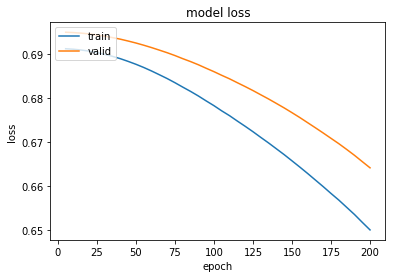

In [33]:
if multi_epoch_analysis:
    plot_history_loss_df = pd.DataFrame(data=plot_history_loss, index=[(i+1) * each_epochs_save_lambda for i in range(len(plot_history_acc))])
    plot_history_val_loss_df = pd.DataFrame(data=plot_history_val_loss, index=[(i+1) * each_epochs_save_lambda for i in range(len(plot_history_acc))])
    
    plt.plot(plot_history_loss_df)
    plt.plot(plot_history_val_loss_df)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_total.png')
    plt.show()    
elif samples_list != None:
    plot_history_loss_df = pd.DataFrame(data=plot_history_loss, index= samples_list)
    plot_history_val_loss_df = pd.DataFrame(data=plot_history_val_loss, index= samples_list)
    
    plt.plot(plot_history_loss_df)
    plt.plot(plot_history_val_loss_df)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('samples')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_total.png')
    plt.show()

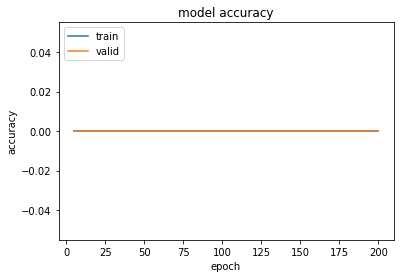

In [34]:
if multi_epoch_analysis:
    plot_history_acc_df = pd.DataFrame(data=plot_history_acc, index=[(i+1) * each_epochs_save_lambda for i in range(len(plot_history_acc))])
    plot_history_val_acc_df = pd.DataFrame(data=plot_history_val_acc, index=[(i+1) * each_epochs_save_lambda for i in range(len(plot_history_acc))])
    
    plt.plot(plot_history_acc_df)
    plt.plot(plot_history_val_acc_df)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/acc_' + interpretation_network_string + filename + '_total.png')
    plt.show()

elif samples_list != None:
    plot_history_acc_df = pd.DataFrame(data=plot_history_acc, index= samples_list)
    plot_history_val_acc_df = pd.DataFrame(data=plot_history_val_acc, index= samples_list)
    
    plt.plot(plot_history_acc_df)
    plt.plot(plot_history_val_acc_df)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('samples')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/acc_' + interpretation_network_string + filename + '_total.png')
    plt.show()


### Load Lambda Scores and Select Interpretation Scores for Plotting

In [35]:
#Load accuracy
if each_epochs_int_training != None:
    path_acc = './data/weights/weights_formula_' + str(n) + size_string_lambda + structure  + str(RANDOM_SEED) + '/history_acc_formula_' + str(n) + size_string_int  + structure  + str(RANDOM_SEED) + '.txt'
else:
    path_acc = './data/weights/history_acc_formula_' + str(n) + '_all' + structure + '42.txt'
    
acc_lambda = pd.read_csv(path_acc, sep = ',')

In [36]:
if not multi_epoch_analysis and samples_list == None:
    mean_acc_lambda = acc_lambda.describe().loc['mean'].values
    mean_acc_int = history['val_accuracy']


    plt.plot(mean_acc_lambda)
    plt.plot(mean_acc_int)
    plt.title('Accuracy Comparison Lambda - Interpretation')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Lambda', 'Interpretation'], loc='upper left')
    plt.show()
    

In [37]:
#Load lambda scores
path_scores_test = './data/weights/history'  + str(size_string_int) + '_variables_' + str(n) + '_epoch_stepwise_' + str(epochs_lambda).zfill(3) + structure  + str(RANDOM_SEED) + '.txt'

lambda_scores_test = pd.read_csv(path_scores_test, sep=',')

In [38]:
print_head = None
if multi_epoch_analysis or samples_list != None:
    print_head = scores_df.head()
print_head

,MAE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,RMSE FV,STD FV PRED,acc_complete,acc_complete_with_treshold,acc_minterm,acc_minterm_with_treshold,categorical_crossentropy
0,"[0.4975, 0.4812]","[21.709, 21.7419]","[-1.0291, -0.9998]","[1.0047, 0.9806]","[2.0195, 2.039]","[0.7029, 0.6914]","[0.49607837082461076, 0.49607837082461076]","[0.0, 0.0]","[1.0, 1.0]","[0.521577, 0.50248]","[0.0, 0.0]","[0.693943, 0.694869]"
1,"[0.4975, 0.4812]","[21.709, 21.7419]","[-1.0291, -0.9998]","[1.0047, 0.9806]","[2.0195, 2.039]","[0.7029, 0.6914]","[0.49607837082461076, 0.49607837082461076]","[0.0, 0.0]","[1.0, 1.0]","[0.521577, 0.50248]","[0.0, 0.0]","[0.69384, 0.694789]"
2,"[0.4945, 0.4787]","[21.8043, 21.985]","[-1.0166, -0.9894]","[0.9986, 0.9755]","[2.0195, 2.039]","[0.7006, 0.6897]","[0.49667815024745415, 0.4969592023877498]","[0.0, 0.0]","[1.0, 1.0]","[0.524182, 0.505456]","[0.0, 0.0]","[0.69368, 0.694665]"
3,"[0.494, 0.4787]","[22.2458, 22.4761]","[-1.0144, -0.99]","[0.9975, 0.9757]","[2.0195, 2.039]","[0.7004, 0.6899]","[0.4976795546711679, 0.49795831222088915]","[0.0, 0.0]","[1.0, 1.0]","[0.526414, 0.505952]","[0.0, 0.0]","[0.693452, 0.694487]"
4,"[0.4891, 0.4772]","[22.4864, 22.5729]","[-0.9943, -0.9838]","[0.9875, 0.9727]","[2.0195, 2.039]","[0.6966, 0.6887]","[0.4985390500387912, 0.49826086429589167]","[0.0, 0.0]","[1.0, 1.0]","[0.52939, 0.510913]","[0.0, 0.0]","[0.693161, 0.694261]"


In [39]:
if multi_epoch_analysis or samples_list != None:
    columns_rename = ('MAE', 'MAPE', 'R2', 'RAAE', 'RMAE', 'RMSE', 'STD PRED', 'acc_complete',
                     'acc_complete_with_treshold', 'acc_minterm', 'acc_minterm_with_treshold', 'categorical_crossentropy')
    scores_df.columns = columns_rename


In [40]:
if multi_epoch_analysis or samples_list != None:
    path = 'data/weights/' + foldername + 'history_loss_formula_' + str(n)  + size_string_lambda + structure + str(RANDOM_SEED) + '.txt'

    binary_crossentropy_lambda = pd.read_csv(path, sep = ',')
    binary_crossentropy_int = plot_history_loss_df



In [42]:
if multi_epoch_analysis or samples_list != None:
    scores_df['binary_crossentropy'] =  (binary_crossentropy_int.values)
    if samples_list == None:
        lambda_scores_test['binary_crossentropy'] = (binary_crossentropy_lambda.mean().values)[::each_epochs_save_lambda]

### Select Columns to Plot

In [43]:
if multi_epoch_analysis or samples_list != None:
    'Reduce the dfs to equal keys for plotting comparison'
    plot_cols = scores_df.columns.intersection(lambda_scores_test.columns)
    scores_lambda = lambda_scores_test[plot_cols]
    scores_int = scores_df[plot_cols]

### Generate Comparison Plots

/home/smarton/anaconda3/envs/masterthesos/lib/python3.6/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


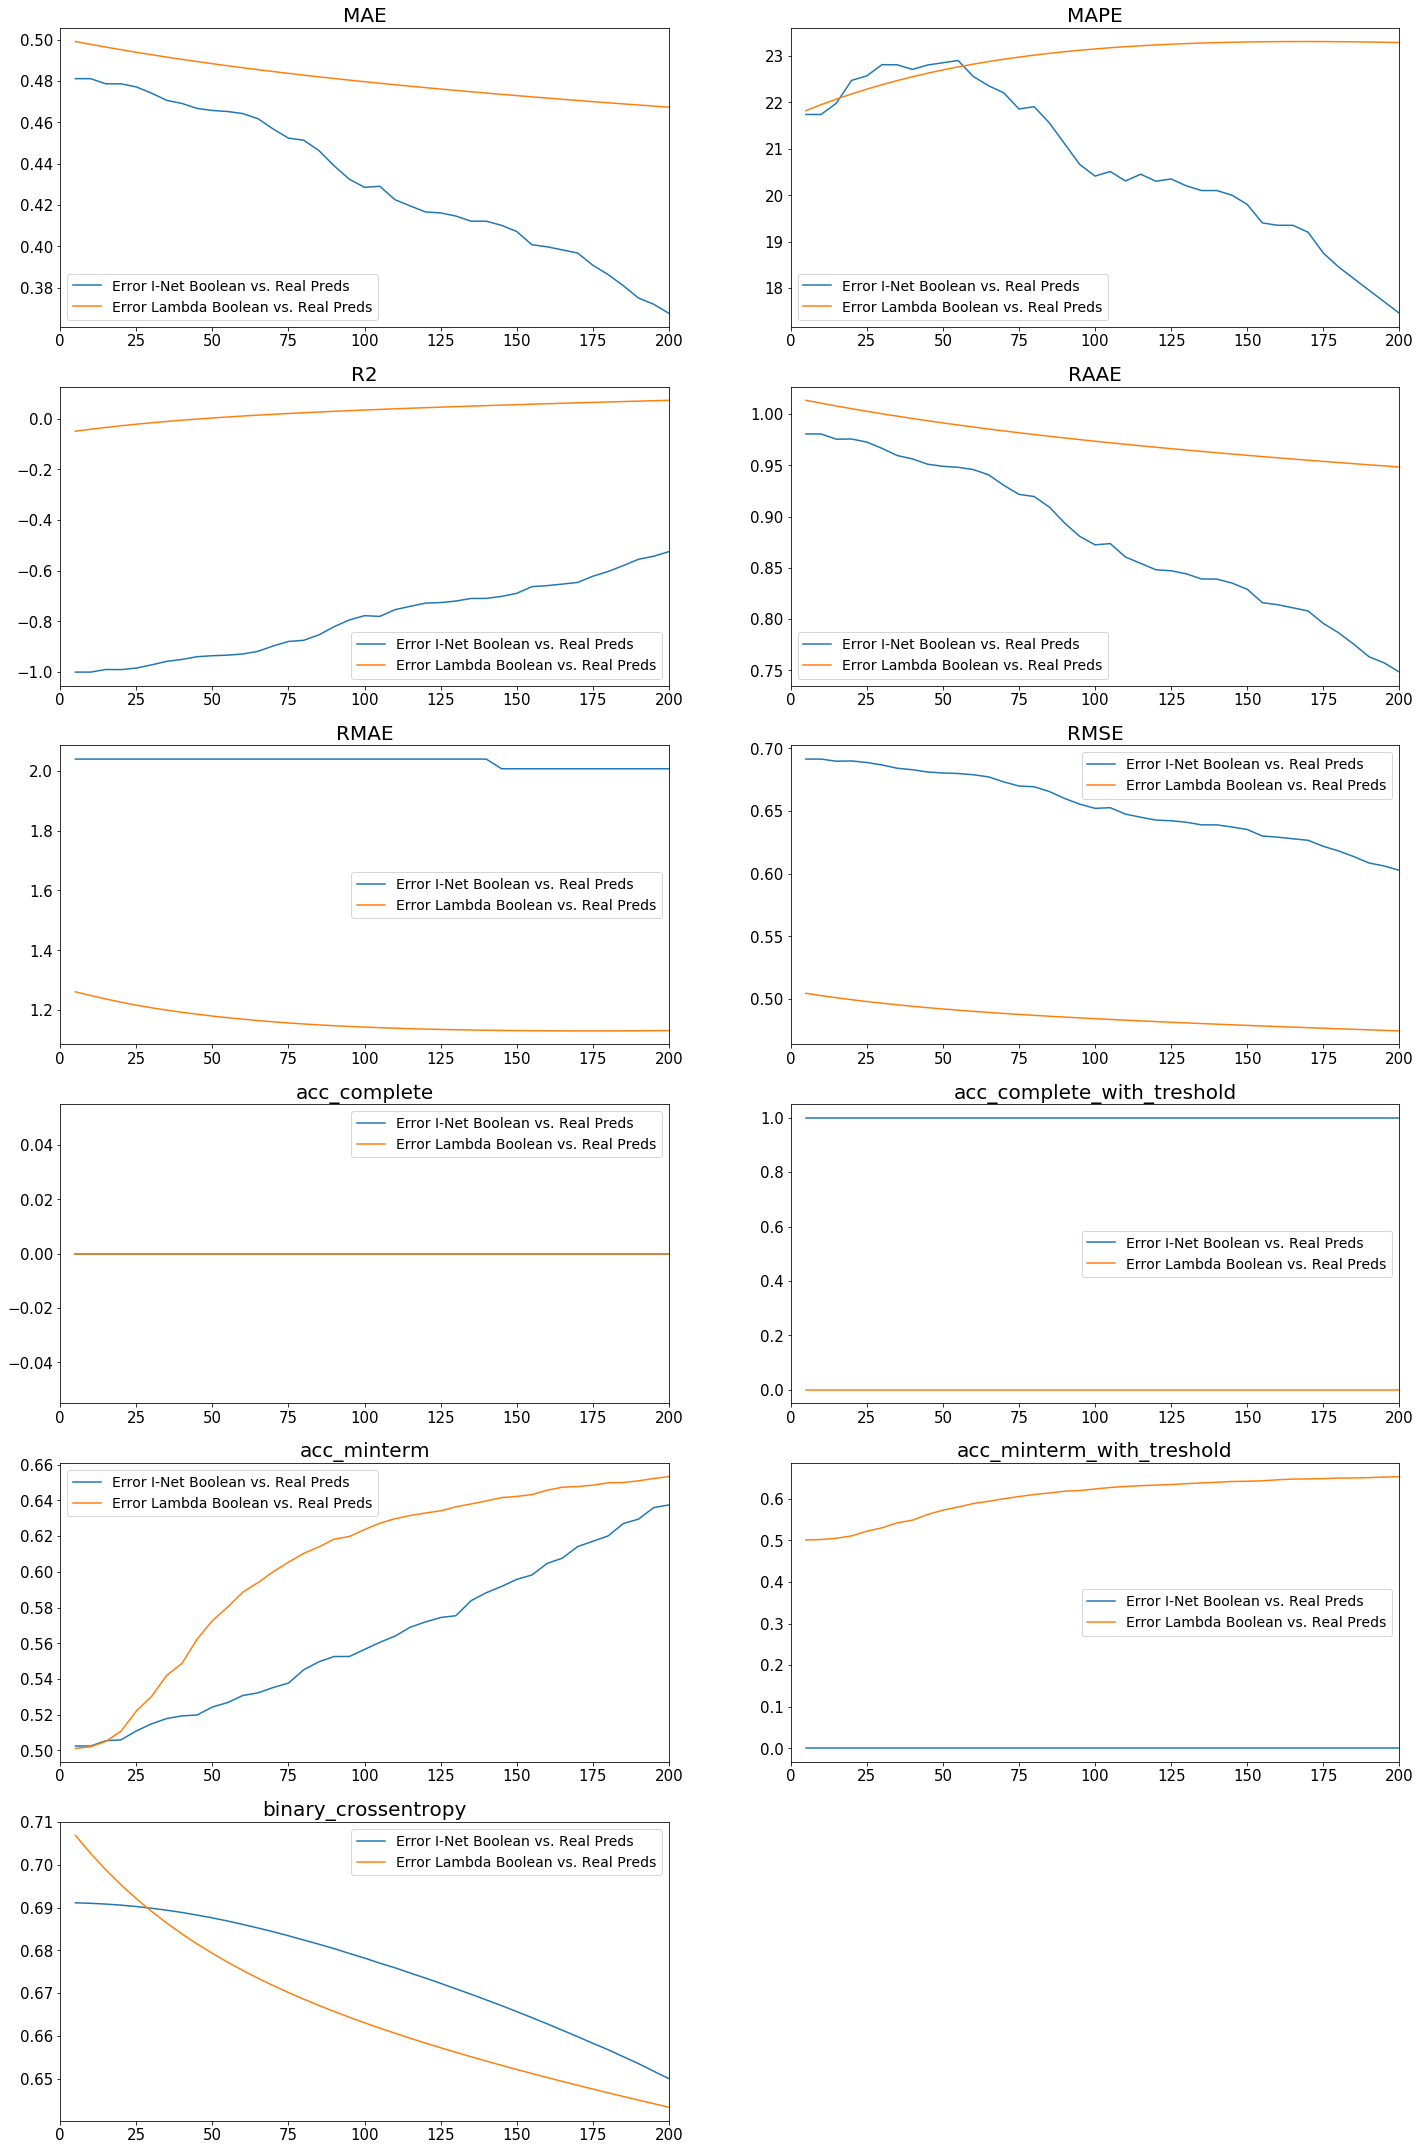

In [44]:
#Generate plot
if multi_epoch_analysis or samples_list != None:
    try:
        # Create target Directory
        os.mkdir('./data/plot_figures/' + interpretation_network_string + '_' + filename + '/')
    except FileExistsError:
        pass

    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(scores_lambda.columns)
    plt.figure(figsize=(12*2, 7*length_plt/2))
    subplot_number = 1


    'Define plot name based on approach'
    plt_err_name = None
    plt_lam_name = None
    if evaluate_zhegalkin:
        plt_err_name = 'Zhegalkin'
    elif evaluate_boolean:
        plt_err_name = 'Boolean'

    'Determine against what we are comparing the losses'    

    if second_approach:
        plt_lam_name = 'Lambda Preds'
    else:
        plt_lam_name = 'Real Preds'


    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for column in scores_int.columns:
        if column == 'binary_crossentropy':
            vals_int = [value_list for value_list in scores_int[column]]
        else:
            vals_int = [value_list[1] for value_list in scores_int[column]]
        vals_lambda = scores_lambda[column].values

        ax = plt.subplot(length_plt//2+1, 2, subplot_number)

        ax.set_title(column, fontsize=20)

        if multi_epoch_analysis:
            ax.plot([(i+1)*each_epochs_int_training for i in range(epochs_lambda//each_epochs_int_training)], vals_int, label='Error I-Net {} vs. {}'.format(plt_err_name, plt_lam_name))
            ax.plot([(i+1)*each_epochs_save_lambda for i in range(epochs_lambda//each_epochs_save_lambda)], vals_lambda, label='Error Lambda {} vs. {}'.format(plt_err_name, plt_lam_name))
            ax.set_xlim([0, epochs_lambda])

        elif samples_list != None:
            vals_lambda = np.concatenate([vals_lambda[-1] for i in samples_list], axis=None)
            ax.plot(samples_list, vals_int, label='Error I-Net {} vs. {}'.format(plt_err_name, plt_lam_name))
            ax.plot(samples_list, vals_lambda, label='Error Lambda {} vs. {}'.format(plt_err_name, plt_lam_name))

        ax.legend(loc="bottom right", fontsize=14)


        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(15)

        subplot_number += 1


    location = './data/plot_figures/'
    folder = interpretation_network_string + '_' + filename + '/'
    file = 'multi_epoch_REAL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(size_string_int) + '_train_' + str(size_string_int) + '_variables_' + str(n) + '.eps'

    path = location + folder + file    

    plt.savefig(path, format='eps')
    plt.show()

    

In [45]:
#Store the values for the plots
if multi_epoch_analysis or samples_list != None:
    if evaluate_boolean:
        exp = '_boolean_'
    elif evaluate_zhegalkin:
        exp = '_zhegalkin_'

    path_int = 'data/plot_values/results_plot_values_int_multiepoch' + exp + str(n)  + size_string_int + structure + str(RANDOM_SEED) + '.txt'
    path_lambda = 'data/plot_values/results_plot_values_lambda_multiepoch' + exp + str(n)  + size_string_int + structure + str(RANDOM_SEED) + '.txt'

    scores_int.to_csv(path_int, index = None)
    scores_lambda.to_csv(path_lambda, index = None)
